In [44]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.utils import image_dataset_from_directory
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [45]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [46]:
# data pipeline
data = image_dataset_from_directory('data', image_size=(224, 224))

Found 1536 files belonging to 3 classes.


In [47]:
# get a single batch (32 images) within pipeline
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [48]:
# image shape
print(batch[0].shape)
# y values
print(batch[1])

(32, 224, 224, 3)
[0 2 2 2 2 0 1 0 1 2 2 1 1 1 0 1 2 0 0 1 1 0 1 1 0 1 1 0 0 2 2 0]


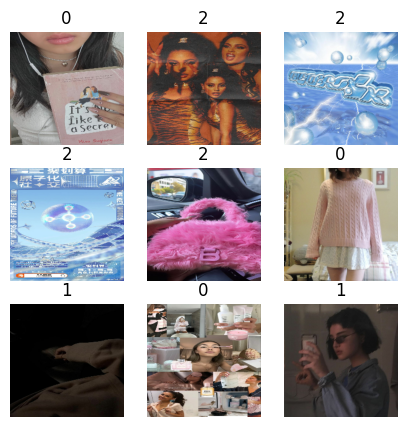

In [49]:
# 0 : coquette :: 1 : grunge :: 2 : y2k
fig, ax = plt.subplots(3, 3, figsize = (5, 5))
for i in range(3):
  for j in range(3):
    ax[i, j].imshow(batch[0][i * 3 + j].astype(int))
    ax[i, j].title.set_text(batch[1][i * 3 + j])
    ax[i, j].axis('off')
plt.show()

In [50]:
# scale data to between 0 and 1 for rgb values instead of 0 to 255
data = data.map(lambda x, y: (x/255, y))
data = data.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

In [55]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
for i in range(5):
    print(batch[1][i])

[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]


/Users/ashley/miniforge3/envs/cv/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


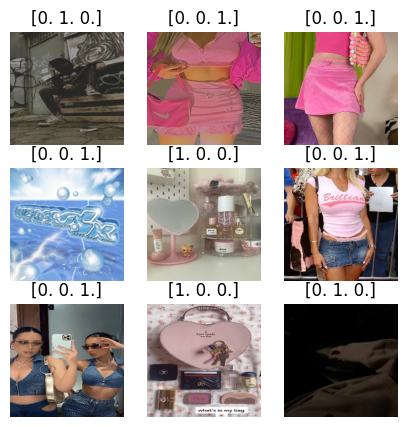

In [56]:
# since rgb values are now between 0 and 1, don't cast to int
# [1, 0, 0] : coquette :: [0, 1, 0] : grunge :: [0, 0, 1] : y2k
fig, ax = plt.subplots(3, 3, figsize = (5, 5))
for i in range(3):
  for j in range(3):
    ax[i, j].imshow(batch[0][i * 3 + j])
    ax[i, j].title.set_text(batch[1][i * 3 + j])
    ax[i, j].axis('off')
plt.show()

In [57]:
num_batches = len(data)
train_size = int((num_batches) * .8)
val_size = int((num_batches) * .1)
test_size = int((num_batches) * .1)
print(str(train_size) + " " + str(val_size) + " " + str(test_size))

38 4 4


In [58]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [59]:
vgg = VGG19(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)

In [60]:
model = Model(inputs = vgg.input, outputs = prediction)
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
  metrics=['categorical_accuracy']
)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [63]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [62]:
results = model.fit(train,
                    validation_data = val,
                    epochs = 20,
                    callbacks = early_stop,
                    batch_size = 32, shuffle = True)

Epoch 1/20
38/38 [==============================] - 41s 956ms/step - loss: 0.9825 - categorical_accuracy: 0.6028 - val_loss: 0.5147 - val_categorical_accuracy: 0.7500
Epoch 2/20
38/38 [==============================] - 40s 1s/step - loss: 0.3697 - categorical_accuracy: 0.8758 - val_loss: 0.3622 - val_categorical_accuracy: 0.8828
Epoch 3/20
38/38 [==============================] - 39s 988ms/step - loss: 0.2392 - categorical_accuracy: 0.9309 - val_loss: 0.3193 - val_categorical_accuracy: 0.9141
Epoch 4/20
38/38 [==============================] - 40s 1s/step - loss: 0.1749 - categorical_accuracy: 0.9622 - val_loss: 0.2938 - val_categorical_accuracy: 0.8828
Epoch 5/20
38/38 [==============================] - 42s 1s/step - loss: 0.1055 - categorical_accuracy: 0.9877 - val_loss: 0.2708 - val_categorical_accuracy: 0.9062
Epoch 6/20
38/38 [==============================] - 42s 1s/step - loss: 0.0847 - categorical_accuracy: 0.9910 - val_loss: 0.2323 - val_categorical_accuracy: 0.9297
Epoch 7/20

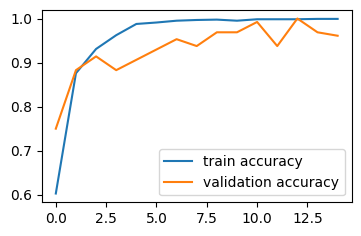

In [66]:
plt.figure(figsize=(4, 2.5))
plt.plot(results.history['categorical_accuracy'], label = 'train accuracy')
plt.plot(results.history['val_categorical_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

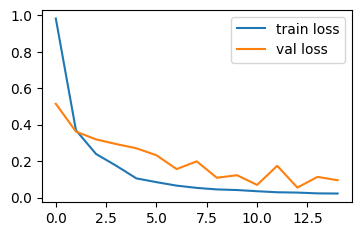

In [67]:
plt.figure(figsize=(4, 2.5))
plt.plot(results.history['loss'], label = 'train loss')
plt.plot(results.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

In [69]:
model.evaluate(test, batch_size = 32)

4/4 [==============================] - 7s 709ms/step - loss: 0.0972 - categorical_accuracy: 0.9844


[0.09721124172210693, 0.984375]

In [93]:
y_true, y_pred, x_wrong, actual, y_wrong = [], [], [], [], []
for x, y in test:
  true = tf.argmax(y, axis = 1)
  pred = tf.argmax(model.predict(x), axis = 1)
  for i in range (len(np.array(true))):
    if np.array(true)[i] != np.array(pred)[i]:
      x_wrong.append(np.array(x[i]))
      actual.append(np.array(true)[i])
      y_wrong.append(np.array(pred)[i])
  y_true.append(true)
  y_pred.append(pred)
y_true = tf.concat(y_true, axis = 0)
y_pred = tf.concat(y_pred, axis=0)

1/1 [==============================] - 0s 63ms/step


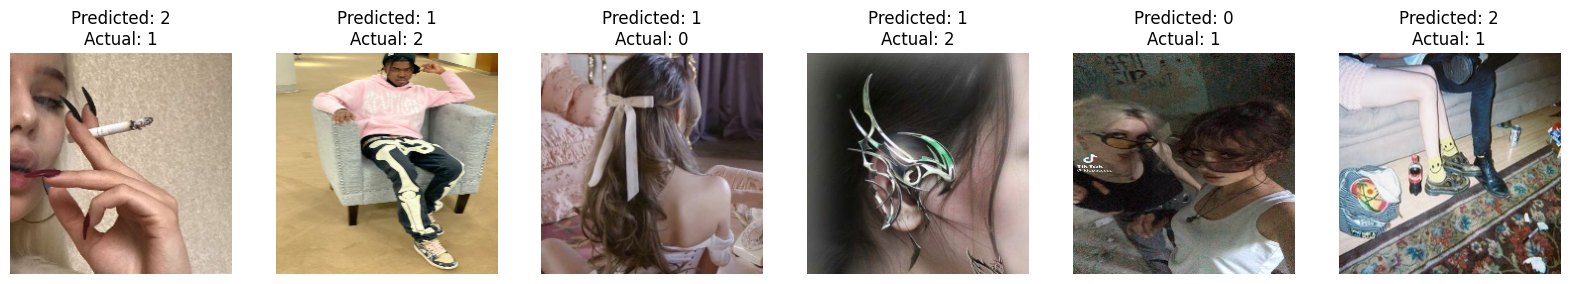

In [94]:
# 0 : coquette :: 1 : grunge :: 2 : y2k
fig, ax = plt.subplots(1, len(x_wrong), figsize = (20, 20))
for i in range(len(x_wrong)):
    ax[i].imshow(x_wrong[i])
    ax[i].title.set_text("Predicted: " + str(y_wrong[i]) + "\nActual: " + str(actual[i]))
    ax[i].axis('off')
plt.show()

In [95]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.93      0.93      0.93        42
           2       0.95      0.95      0.95        41

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128



In [96]:
print(confusion_matrix(y_true, y_pred, normalize = "true"))
print(confusion_matrix(y_true, y_pred))

[[0.97777778 0.02222222 0.        ]
 [0.02380952 0.92857143 0.04761905]
 [0.         0.04878049 0.95121951]]
[[44  1  0]
 [ 1 39  2]
 [ 0  2 39]]
